In [1]:
using LatticeModels
using Plots, LinearAlgebra
σ = [[0 1; 1 0], [0 -im; im 0], [1 0; 0 -1]]

3-element Vector{Matrix{Complex{Int64}}}:
 [0 + 0im 1 + 0im; 1 + 0im 0 + 0im]
 [0 + 0im 0 - 1im; 0 + 1im 0 + 0im]
 [1 + 0im 0 + 0im; 0 + 0im -1 + 0im]

## Variable ways to define a lattice with a hamiltonian operator

In [3]:
l = SquareLattice(10, 10)
H = @hamiltonian begin # Hofstadter model
    lattice := l
    @hop axis=1
    @hop axis=2
end

200×200 LatticeMatrix with inner type Matrix{ComplexF64}
on Basis with 2-dimensional internal phase space
on 10×10 square lattice

In [ ]:
l = SquareLattice(10, 10)
H = @hamiltonian begin # Chern insulator
    lattice := l
    @diag σ[3]
    @hop axis=1 (σ[3] - im * σ[1]) / 2
    @hop axis=2 (σ[3] - im * σ[2]) / 2
end

200×200 LatticeMatrix with inner type Matrix{ComplexF64}
on Basis with 2-dimensional internal phase space
on 10×10 square lattice

In [18]:
l = HoneycombLattice(10, 10) do x, y
    -8.5 < √3 * x + y < 9.5
end
H = @hamiltonian begin
    lattice := l
    @diag σ[3]
    @hop site_indices=(2, 1) axis=1 (σ[3] - im * (σ[1] * √3 / 2 - σ[2]/2)) / 2
    @hop site_indices=(2, 1) axis=2 (σ[3] - im * σ[2]) / 2
    @hop site_indices=(2, 1) (σ[3] - im * (-σ[1] * √3 / 2 - σ[2]/2)) / 2
end

MethodError: MethodError: no method matching size(::SubLattice{HoneycombLattice})
Closest candidates are:
  size(!Matched::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}) at C:\Users\Alexander\.julia\juliaup\julia-1.8.0+0.x64\share\julia\stdlib\v1.8\LinearAlgebra\src\qr.jl:581
  size(!Matched::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}, !Matched::Integer) at C:\Users\Alexander\.julia\juliaup\julia-1.8.0+0.x64\share\julia\stdlib\v1.8\LinearAlgebra\src\qr.jl:580
  size(!Matched::Union{Cholesky, CholeskyPivoted}) at C:\Users\Alexander\.julia\juliaup\julia-1.8.0+0.x64\share\julia\stdlib\v1.8\LinearAlgebra\src\cholesky.jl:514
  ...

## Calculate the local Chern marker

In [21]:
bas = H.basis
X, Y = coord_operators(bas)
sp = Spectrum(H)
P = filled_projector(sp)

ch = @on_lattice 4π * im * P * X * (I - P) * Y * P
ch_values = diag_aggregate((m -> real(tr(m))), ch)
d_values = diag_aggregate((m -> real(tr(m))), P)

p = plot(layout=2, size=(1200, 400))
plot!(p[1], ch_values, ms=10)
plot!(p[2], d_values, ms=10)

LatticeValue with inner type Vector{Float64}
on 10×10 square lattice

In [2]:
## Unitary evolution

In [3]:
time_domain = 0:0.1:30
Bf = 0.01
τ = 30
l = SquareLattice(20, 20)
X, Y = coord_operators(l, 2)
h_field(m, t) = @hamiltonian begin
    lattice := l
    field := Landau(Bf * t / τ)
    @diag [m 0; 0 -m]
    @hop axis=1 [1 -im; -im -1] / 2
    @hop axis=2 [1 1; -1 -1] / 2
end

h_bound(bound) = @hamiltonian begin
    lattice := l
    @diag (x, y) -> begin
        if x < bound
            return [-3 0; 0 3]
        else
            return [3 0; 0 -3]
        end
    end
    @hop axis=1 [1 -im; -im -1] / 2
    @hop axis=2 [1 1; -1 -1] / 2
end

h_sq(bound) = @hamiltonian begin
    lattice := l
    @diag (site, x, y) -> begin
        if abs(x) < bound && abs(y) < 5
            return [-3 0; 0 3]
        else
            return [3 0; 0 -3]
        end
    end
    @hop axis=1 [1 -im; -im -1] / 2
    @hop axis=2 [1 1; -1 -1] / 2
end

h_sq (generic function with 1 method)

In [ ]:

HB0 = h_bound(-2)
HB1 = h_bound(2)
h(t) = HB0 * (1 - t) + HB1 * t
P0 = filled_projector(Spectrum(HB0))

a = Animation()
@evolution {
    P0 => h(min(t / τ, 1)) => P
 } for t in 0:0.1:2τ
    ch = 4pi * im * P * X * (I - P) * Y * P
    d_values = diag_aggregate((m -> real(tr(m))), ch)
    plot(d_values, lab="LCM")
    title!("t = $t")
    frame(a)
end

In [4]:
H = h_field(3, 0)
P0 = filled_projector(Spectrum(H))
p = plot(layout = 2)hg
plot!(p[1], diag_aggregate((m -> real(tr(m))), 4pi * im * P0 * X * (I - P0) * Y * P0))
plot!(p[2], diag_aggregate((m -> real(m[begin])), H))

┌ Warning: avoid using lattice operators and matrices in one function call
└ @ LatticeModels c:\Users\Alexander\Julia Projects\LatticeModels\src\lattice_values.jl:168


UndefVarError: UndefVarError: data not defined

┌ Info: Saved animation to 
│   fn = c:\Users\Alexander\Julia Projects\LatticeModels\lol.gif
└ @ Plots C:\Users\Alexander\.julia\packages\Plots\yJrrq\src\animation.jl:137


Plots.AnimatedGif("c:\\Users\\Alexander\\Julia Projects\\LatticeModels\\lol.gif")
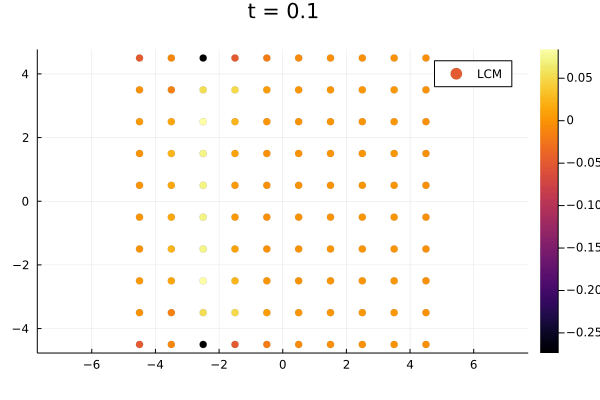

In [7]:
gif(a, "lol.gif")

In [13]:
using BenchmarkTools
import ProfileVega as PV

In [6]:
# Before
@benchmark @hamiltonian begin 
    lattice := l
    field := Landau(0.5)
    @diag [1 0; 0 -1]
    @hop axis=1 [1 -im; -im -1] / 2
    @hop axis=2 [1 1; -1 -1] / 2
end

BenchmarkTools.Trial: 238 samples with 1 evaluation.
 Range (min … max):  16.710 ms … 34.280 ms  ┊ GC (min … max):  0.00% … 18.00%
 Time  (median):     21.073 ms              ┊ GC (median):    15.18%
 Time  (mean ± σ):   21.047 ms ±  2.544 ms  ┊ GC (mean ± σ):  12.20% ±  8.67%

     ▁▁▆▁▃▁▁      ▁ █▅ ▄▃▅▁▁▃▁▁▄                               
  ▃▄▅███████▁▅▃▆▃▅█▇████████████▇▆▆▆▅▁▅▁▃▁▃▁▃▁▁▃▁▁▁▁▁▃▃▁▁▁▁▁▄ ▄
  16.7 ms         Histogram: frequency by time        29.5 ms <

 Memory estimate: 29.25 MiB, allocs estimate: 374255.

In [11]:
# optimize lattice iter
# optimize hopping match checker
# save propagate result
# no function call if not defined
# reduce field apply overhead
@benchmark @hamiltonian begin
    lattice := l
    field := Landau(0.5)
    @diag [1 0; 0 -1]
    @hop axis=1 [1 -im; -im -1] / 2
    @hop axis=2 [1 1; -1 -1] / 2
end

BenchmarkTools.Trial: 4533 samples with 1 evaluation.
 Range (min … max):  628.800 μs …   8.152 ms  ┊ GC (min … max):  0.00% … 83.62%
 Time  (median):     775.700 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.097 ms ± 811.007 μs  ┊ GC (mean ± σ):  15.70% ± 16.67%

  █▇▅▅▄▄▄▃▄▄▃▃▂▁▁                                               ▁
  █████████████████▇█▇▇▅▆▅▃▅▅▁▅▃▁▅▁▆▆▆▇███▇██▇█▆█▆▇▅▅▅▅▆▅▅▄▄▆▅▅ █
  629 μs        Histogram: log(frequency) by time        4.6 ms <

 Memory estimate: 4.57 MiB, allocs estimate: 4543.

In [6]:
hp = Hopping(axis=1, hop_operator = [1 -im; -im -1] / 2)

Hopping
Connects site #1 with site #1 translated by [1]
Boundary conditions: open
Hopping operator matrix: ComplexF64[0.5 + 0.0im 0.0 - 0.5im; 0.0 - 0.5im -0.5 + 0.0im]

In [7]:
@benchmark hopping_operator(_ -> true, l, hp)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  235.000 μs …   5.072 ms  ┊ GC (min … max):  0.00% … 93.36%
 Time  (median):     264.850 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   337.559 μs ± 239.668 μs  ┊ GC (mean ± σ):  10.59% ± 13.34%

  █▆▆▅▄▄▄▄▃▃▂▂▂▁▁▁                                              ▂
  ██████████████████▇▇▇▇▅▅▄▄▅▄▁▁▃▁▄▁▁▄▁▁▁▁▁▁▁▁▅▆██▇▇▅▆▅▆▅▆▆▅▄▅▅ █
  235 μs        Histogram: log(frequency) by time       1.49 ms <

 Memory estimate: 1.29 MiB, allocs estimate: 995.

In [4]:
@benchmark diag_operator([1 0; 0 1], l)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   9.700 μs …   4.604 ms  ┊ GC (min … max):  0.00% … 97.36%
 Time  (median):     17.400 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   38.504 μs ± 107.316 μs  ┊ GC (mean ± σ):  22.59% ± 10.99%

  █▇▅▅▄▂▂▁ ▁ ▂▃                                                ▂
  ████████████████▇▆▇▆▅▇▇▆▇▅▆▆▆▆▇▅▆▄▄▄▅▄▁▁▃▃▄▁▃▄▁▄▁▁▄▁▁▁▃▁▄▅▆▇ █
  9.7 μs        Histogram: log(frequency) by time       427 μs <

 Memory estimate: 626.33 KiB, allocs estimate: 24.

In [16]:
@macroexpand @hamiltonian begin
    lattice := l
    field := Landau(0.5)
    @diag [1 0; 0 -1]
    @hop axis=1 [1 -im; -im -1] / 2
    @hop axis=2 [1 1; -1 -1] / 2
end

quote
    #= c:\Users\Alexander\Julia Projects\LatticeModels\src\hamiltonian.jl:76 =#
    var"#74#H" = LatticeModels._fast_sum(LatticeModels.diag_operator([1 0; 0 -1], l), LatticeModels.hopping_operator((site->begin
                        #= c:\Users\Alexander\Julia Projects\LatticeModels\src\hamiltonian.jl:46 =#
                        true
                    end), l, LatticeModels.Hopping(hop_operator = [1 -im; -im -1] / 2, axis = 1), field = Landau(0.5)), LatticeModels.hopping_operator((site->begin
                        #= c:\Users\Alexander\Julia Projects\LatticeModels\src\hamiltonian.jl:46 =#
                        true
                    end), l, LatticeModels.Hopping(hop_operator = [1 1; -1 -1] / 2, axis = 2), field = Landau(0.5)))
end

In [10]:
# PV.@profview for _ in 1:100 
@macroexpand    @hamiltonian begin
        lattice := l
        field := Landau(0.5)
        @diag [1 0; 0 -1]
        @hop axis=1 [1 -im; -im -1] / 2
        @hop axis=2 [1 1; -1 -1] / 2
    end
# end

:(LatticeModels.diag_operator(l, [1 0; 0 -1]) + LatticeModels.hopping_operator(l, LatticeModels.Hopping(hop_operator = [1 -im; -im -1] / 2, axis = 1), field = Landau(0.5)) + LatticeModels.hopping_operator(l, LatticeModels.Hopping(hop_operator = [1 1; -1 -1] / 2, axis = 2), field = Landau(0.5)))

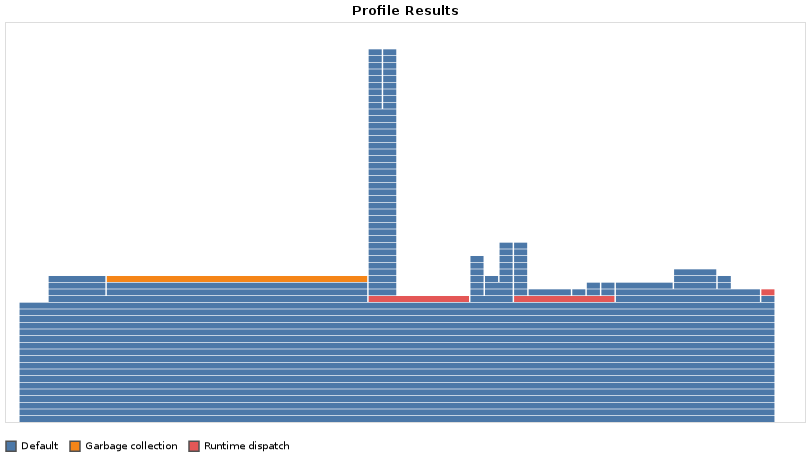

In [11]:
PV.@profview for _ in 1:100 hopping_operator(_ -> true, l, hp) end

In [15]:
X

UndefVarError: UndefVarError: X not defined

In [14]:
@benchmark x * y

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  235.700 μs …   6.265 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     420.750 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   473.602 μs ± 312.121 μs  ┊ GC (mean ± σ):  4.29% ± 6.88%

  ▅       █▃                                                     
  █▄▃▂▂▂▃▅██▇▆▅▃▄▄▆▇▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂ ▃
  236 μs           Histogram: frequency by time         1.24 ms <

 Memory estimate: 312.55 KiB, allocs estimate: 2.

In [23]:
o = @on_lattice one(X)

200×200 LatticeMatrix with inner type Matrix{Float64}
on Basis with 2-dimensional internal phase space
on 10×10 square lattice

In [25]:
X

200×200 LatticeMatrix with inner type SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}
on Basis with 2-dimensional internal phase space
on 10×10 square lattice

In [25]:
macro dict(expr)
    if !Meta.isexpr(expr, :braces)
        error("braces expected")
    end
    kwpairs = []
    for arg in expr.args
        if Meta.isexpr(arg, :call) && arg.args[1] === :(:)
            key, value = arg.args[2:3]
            if Meta.isexpr(value, :braces)
                value = (@macroexpand @dict($value))
            end
            push!(kwpairs, :($(esc(key)) => $(esc(value))))
        else
            error("invalid pair format")
        end
    end
    quote
        Dict($(kwpairs...))
    end
end

@dict (macro with 1 method)

In [26]:
a = 3
b = 5

5

In [27]:
(@dict{2:3, 4:5, a:{2:3}})[3]

LoadError: LoadError: braces expected
in expression starting at c:\Users\Alexander\Julia Projects\LatticeModels\demo.ipynb:1

In [6]:
X, Y = LatticeModels.coord_operators(l, 2)

2-element Vector{LatticeVecOrMat{SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}}}:
 LatticeVecOrMat{SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}}([-4.5 -0.0 … 0.0 0.0; -0.0 -4.5 … 0.0 0.0; … ; 0.0 0.0 … 4.5 0.0; 0.0 0.0 … 0.0 4.5], Basis(SquareLattice([10, 10]), 2))
 LatticeVecOrMat{SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}}([-4.5 -0.0 … 0.0 0.0; -0.0 -4.5 … 0.0 0.0; … ; 0.0 0.0 … 4.5 0.0; 0.0 0.0 … 0.0 4.5], Basis(SquareLattice([10, 10]), 2))

In [6]:
@benchmark LatticeModels.apply_field!(H, Landau(3))

BenchmarkTools.Trial: 633 samples with 1 evaluation.
 Range (min … max):  4.133 ms … 53.724 ms  ┊ GC (min … max): 0.00% … 32.17%
 Time  (median):     7.308 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.895 ms ±  3.356 ms  ┊ GC (mean ± σ):  8.56% ± 14.34%

  ▂▅▆▄▅▂▁▄▄▃▆▃▄█▂▆▃▅▁▁                                        
  ████████████████████▆▇▇▇▅▄▆▄▄▄▄▄▄▄▄▄▃▄▃▇▃▄▃▁▃▂▁▂▁▁▂▁▁▁▁▁▂▂ ▄
  4.13 ms        Histogram: frequency by time        18.3 ms <

 Memory estimate: 5.26 MiB, allocs estimate: 99913.

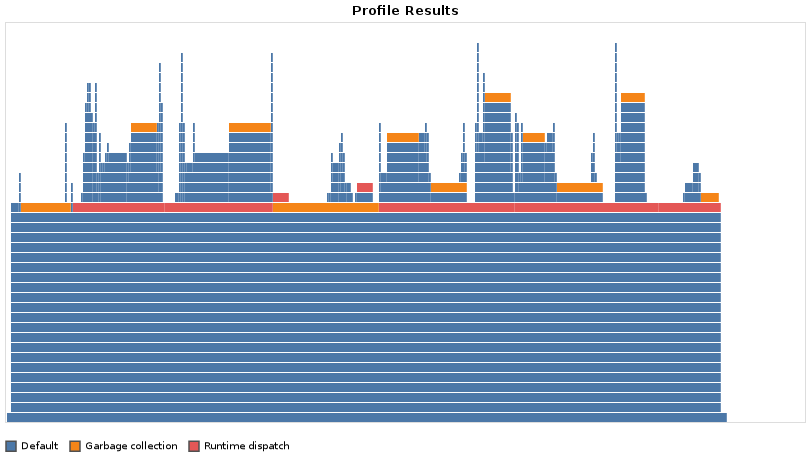

In [7]:

PV.@profview for _ in 1:100 LatticeModels.apply_field!(H, Landau(3)) end

In [11]:
LatticeModels.apply_field!

apply_field! (generic function with 1 method)

In [10]:
a = rand(1000)
b = rand(1000)
c = copy(a)

1000-element Vector{Float64}:
 0.13359100107328037
 0.5480336538503929
 0.2848601211888552
 0.24070939498446753
 0.02324464820069161
 0.0841201348557683
 0.17622365896361714
 0.28260065620712316
 0.9242730798982755
 0.5428709613531257
 ⋮
 0.7805813262085545
 0.30580879235470826
 0.2522946011573455
 0.40795188898283463
 0.3722750350069084
 0.11793028351701229
 0.47671163713283093
 0.2597501889401578
 0.04715808237661889

In [13]:
@benchmark c + b

BenchmarkTools.Trial: 10000 samples with 186 evaluations.
 Range (min … max):  633.333 ns … 39.625 μs  ┊ GC (min … max):  0.00% … 95.23%
 Time  (median):       1.006 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.893 μs ±  2.733 μs  ┊ GC (mean ± σ):  19.79% ± 14.85%

  █▇▆▅▄▃▂▂▃▄▃▂▂▂▂▁▁                                            ▂
  █████████████████████▇▆▆▆▆▆▅▆▆▆▆▆▆▆▅▅▆▅▅▄▅▅▅▆▅▅▅▄▄▅▅▄▄▃▄▂▂▅▄ █
  633 ns        Histogram: log(frequency) by time      13.6 μs <

 Memory estimate: 7.94 KiB, allocs estimate: 1.